In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
# import geopandas as gpd
import json
import requests
import os

In [2]:
## J'ai aussi du copier-coller le fichier csv dans le repertoire "geopandas_env"
df_arbres_brut = pd.read_csv("p2-arbres-fr.csv", sep=";")

In [3]:
df_travail=df_arbres_brut.copy()
df_travail.head()

,id,type_emplacement,domanialite,arrondissement,complement_addresse,numero,lieu,id_emplacement,libelle_francais,genre,espece,variete,circonference_cm,hauteur_m,stade_developpement,remarquable,geo_point_2d_a,geo_point_2d_b
0,99874,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,19,Marronnier,Aesculus,hippocastanum,NaN,20,5,NaN,0.0,48.857620,2.320962
1,99875,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,20,If,Taxus,baccata,NaN,65,8,A,NaN,48.857656,2.321031
2,99876,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,21,If,Taxus,baccata,NaN,90,10,A,NaN,48.857705,2.321061
3,99877,Arbre,Jardin,PARIS 7E ARRDT,NaN,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,22,Erable,Acer,negundo,NaN,60,8,A,NaN,48.857722,2.321006
4,99878,Arbre,Jardin,PARIS 17E ARRDT,NaN,NaN,PARC CLICHY-BATIGNOLLES-MARTIN LUTHER KING,000G0037,Arbre à miel,Tetradium,daniellii,NaN,38,0,NaN,NaN,48.890435,2.315289


<AxesSubplot:>

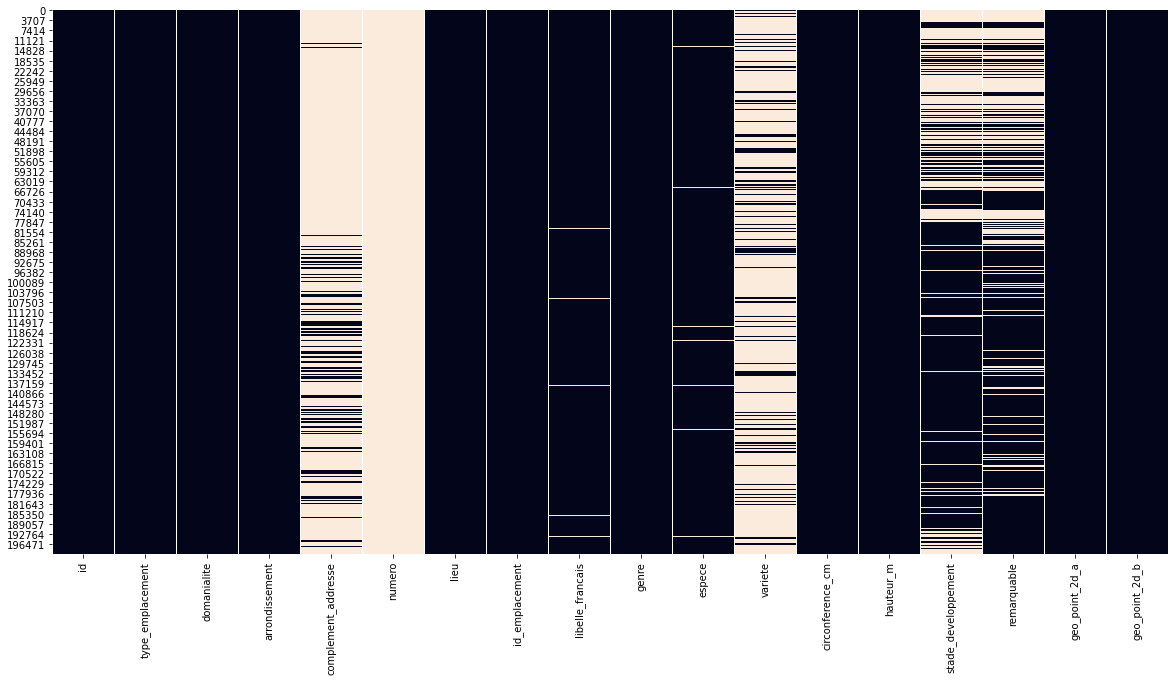

In [4]:
# cartographie des données manquantes
plt.figure(figsize=(20,10))
sns.heatmap(df_travail.isna(), cbar=False)

In [5]:
# Les colonnes de df_travail avec plus de 80% de données manquantes sont retirées et on crée un nouveau dataframe de travail
df_travail2=df_travail[df_travail.columns[(df_travail.isna().sum()/df_travail.shape[0])<0.8]]

<AxesSubplot:>

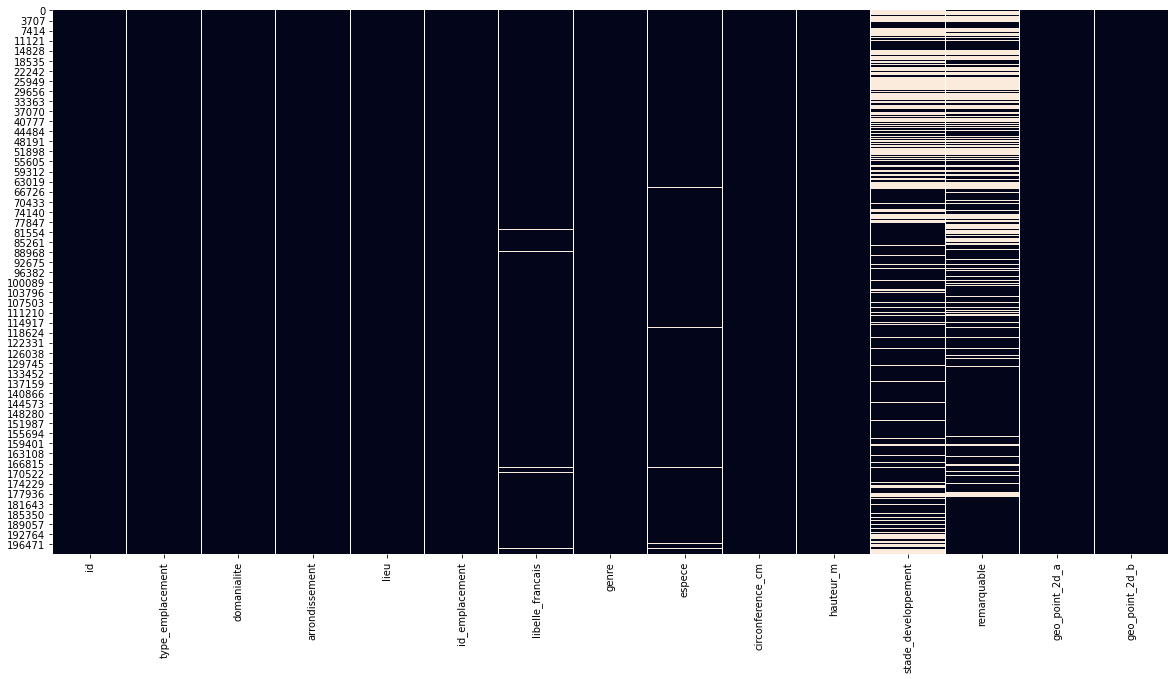

In [6]:
# Vérification des données manquantes du nouveau dataframe df_travail2
plt.figure(figsize=(20,10))
sns.heatmap(df_travail2.isna(), cbar=False)

In [7]:
# La colonne id est retirée car inutile
df_travail2 = df_travail2.drop('id', axis=1)
df_travail2.head()
df_travail2.shape

(200137, 14)

In [8]:
# résumé statistique de df_travail2
df_travail2.describe()

,circonference_cm,hauteur_m,remarquable,geo_point_2d_a,geo_point_2d_b
count,200137.000000,200137.000000,137039.000000,200137.000000,200137.000000
mean,83.380479,13.110509,0.001343,48.854491,2.348208
std,673.190213,1971.217387,0.036618,0.030234,0.051220
min,0.000000,0.000000,0.000000,48.742290,2.210241
25%,30.000000,5.000000,0.000000,48.835021,2.307530
50%,70.000000,8.000000,0.000000,48.854162,2.351095
75%,115.000000,12.000000,0.000000,48.876447,2.386838
max,250255.000000,881818.000000,1.000000,48.911485,2.469759


In [9]:
# On continue avec le nouveau dataframe df_travail3
df_travail3=df_travail2.copy()
# retirer lignes avec circonference  nulle
df_travail3.drop(df_travail3[df_travail3['circonference_cm']==0].index, inplace=True)
# retirer lignes avec diamètre > 450 cm
df_travail3.drop(df_travail3[df_travail3['circonference_cm']>=450].index, inplace=True)
# retirer lignes avec hauteur nulle
df_travail3.drop(df_travail3[df_travail3['hauteur_m']==0].index, inplace=True)
# retirer lignes avec hauteur > 40 m
df_travail3.drop(df_travail3[df_travail3['hauteur_m']>=40].index, inplace=True)

In [10]:
# on refait un head() pour savoir quelles colonnes enlever
df_travail3.head()

,type_emplacement,domanialite,arrondissement,lieu,id_emplacement,libelle_francais,genre,espece,circonference_cm,hauteur_m,stade_developpement,remarquable,geo_point_2d_a,geo_point_2d_b
0,Arbre,Jardin,PARIS 7E ARRDT,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,19,Marronnier,Aesculus,hippocastanum,20,5,NaN,0.0,48.857620,2.320962
1,Arbre,Jardin,PARIS 7E ARRDT,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,20,If,Taxus,baccata,65,8,A,NaN,48.857656,2.321031
2,Arbre,Jardin,PARIS 7E ARRDT,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,21,If,Taxus,baccata,90,10,A,NaN,48.857705,2.321061
3,Arbre,Jardin,PARIS 7E ARRDT,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,22,Erable,Acer,negundo,60,8,A,NaN,48.857722,2.321006
7,Arbre,Jardin,PARIS 16E ARRDT,SQUARE ALEXANDRE ET RENE PARODI / 1 PLACE DE L...,35,Platane,Platanus,x hispanica,260,17,NaN,NaN,48.876722,2.280222


In [11]:
# On s'interesse désormais aux libellés des arbres (erable, peuplier, maronnier, etc.).
# On ne garde que 5 colonnes: lieu, libellé, coodonnées GPS, remarquable (oui/non)
df_travail3.drop(columns = ['type_emplacement','domanialite','arrondissement','id_emplacement','genre','espece','circonference_cm','hauteur_m', 'stade_developpement'], inplace = True)

In [12]:
df_travail3.head()

,lieu,libelle_francais,remarquable,geo_point_2d_a,geo_point_2d_b
0,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,Marronnier,0.0,48.857620,2.320962
1,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,If,NaN,48.857656,2.321031
2,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,If,NaN,48.857705,2.321061
3,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,Erable,NaN,48.857722,2.321006
7,SQUARE ALEXANDRE ET RENE PARODI / 1 PLACE DE L...,Platane,NaN,48.876722,2.280222


In [13]:
#on enlève les lignes avec des NaN:
df_travail3.dropna(how = 'any', axis = 0 , inplace = True)

In [14]:
df_travail3.shape

(126000, 5)

In [15]:
df_travail.groupby('remarquable').count()

,id,type_emplacement,domanialite,arrondissement,complement_addresse,numero,lieu,id_emplacement,libelle_francais,genre,espece,variete,circonference_cm,hauteur_m,stade_developpement,geo_point_2d_a,geo_point_2d_b
remarquable,,,,,,,,,,,,,,,,,
0.0,136855,136855,136854,136855,28564,0,136855,136855,135359,136839,135649,24501,136855,136855,120662,136855,136855
1.0,184,184,184,184,134,0,184,184,183,184,184,16,184,184,182,184,184


In [16]:
df_remarquables = df_travail3[df_travail3['remarquable']==1]

In [17]:
df_remarquables.head()

,lieu,libelle_francais,remarquable,geo_point_2d_a,geo_point_2d_b
1626,PARC DES BUTTES CHAUMONT,Sophora,1.0,48.881469,2.383680
1867,PARC DES BUTTES CHAUMONT,Marronnier,1.0,48.880080,2.385710
1868,PARC DES BUTTES CHAUMONT,Marronnier,1.0,48.880116,2.385667
1889,PARC DES BUTTES CHAUMONT,Arbre aux quarante écus,1.0,48.882322,2.384088
3223,PARC DES BUTTES CHAUMONT,If,1.0,48.877043,2.380500


## A présent nous passons à situer les arbres remarquables sur une carte à l'aide de Folium

### a) 1ère approche: avec un fichier GeoJson

In [18]:
# df_remarquables2 = df_remarquables[['geo_point_2d_a','geo_point_2d_b']]
df_remarquables3 = df_remarquables.drop(columns=['lieu', 'libelle_francais', 'remarquable'])

In [19]:
df_remarquables3.head()

,geo_point_2d_a,geo_point_2d_b
1626,48.881469,2.383680
1867,48.880080,2.385710
1868,48.880116,2.385667
1889,48.882322,2.384088
3223,48.877043,2.380500


In [20]:
arbres_map = folium.Map(location=[48.854491,2.348208], zoom_start=12)

#### ci-dessous un bout de code copié-collé d'une page web: 

https://geoffboeing.com/2015/10/exporting-python-data-geojson/

In [21]:
#df_remarquables3.to_json('Arbres_remarquables.json',orient="records")
#df_remarquables3.to_file('Arbres_remarquables.geojson', driver='GeoJSON')

def df_to_geojson(df, properties, lat='latitude', lon='longitude'):
    geojson = {'type':'FeatureCollection', 'features':[]}
    for _, row in df.iterrows():
        feature = {'type':'Feature',
                   'properties':{},
                   'geometry':{'type':'Point',
                               'coordinates':[]}}
        feature['geometry']['coordinates'] = [row[lon],row[lat]]
        for prop in properties:
            feature['properties'][prop] = row[prop]
        geojson['features'].append(feature)
    return geojson

geojsonf=df_to_geojson(df_remarquables,[], lat='geo_point_2d_a', lon='geo_point_2d_b')

In [22]:
# le print ci-dessous est inutile et prend beaucoup de "volume"
# print(json.dumps(geojsonf, indent=2, sort_keys=True))

In [23]:
#on ajoute les coordonnées récupérées dans le fichier Json
#arbres_map.add_child(folium.GeoJson(geojsonf))
folium.GeoJson(geojsonf, name="geojson").add_to(arbres_map)
#on affiche la carte ainsi obtenue
arbres_map

### b) Maintenant, 2ème approche avec une boucle for (elle se justifie car nous n'avons pas beaucoup d'arbres remarquables)

In [24]:
df_remarquables.head()

,lieu,libelle_francais,remarquable,geo_point_2d_a,geo_point_2d_b
1626,PARC DES BUTTES CHAUMONT,Sophora,1.0,48.881469,2.383680
1867,PARC DES BUTTES CHAUMONT,Marronnier,1.0,48.880080,2.385710
1868,PARC DES BUTTES CHAUMONT,Marronnier,1.0,48.880116,2.385667
1889,PARC DES BUTTES CHAUMONT,Arbre aux quarante écus,1.0,48.882322,2.384088
3223,PARC DES BUTTES CHAUMONT,If,1.0,48.877043,2.380500


In [25]:
m = folium.Map(location=[48.864716, 2.349014], zoom_start=13)
tooltip = "Cliquez moi!"
for row in df_remarquables.itertuples():
    # print(row)
    popup = "Je suis un arbre remarquable. On m'appelle couramment {}. Vous pouvez me rencontrer {}".format(row[2], row[1])
    folium.Marker(
        [row[4], row[5]], popup=popup, tooltip=tooltip, icon=folium.Icon(color='green', icon='pagelines', prefix='fa')
    ).add_to(m)

In [26]:
m

### RQ: j'ai du faire beaucoup de manips afin d'essayer d'intégrer geopandas (dont j'aurais eu éventuellement besoin par la suite): créer un environnement virtuel (geopandas_env) pui lui installer toutes les librairies du "root" non présentes: matplotlib, seaborn, folium.... pas simple!

## Remarque finale:
### Après avoir obtenu la 1ère carte, j'ai tenté plusieurs approches avec "geopandas" pour éventuellement trouver le plus court chemin entre deux arbres situés sur la carte... mais cela a été chronophage et sans résultat probant

### Voici par exemple ce que j'aurais voulu implémenter (mais où j'ai rencontré des problèmes avec GeoPandas)

https://makina-corpus.com/blog/metier/2019/python-carto?fbclid=IwAR1hXOF4Sl7Gd_HnLopR5eObDZG8dXVahb45toROoXIlFgYo7LyEDqLMUnk


### PS:voici deux liens "utiles", mais non exploités:

https://towardsdatascience.com/find-and-plot-your-optimal-path-using-plotly-and-networkx-in-python-17e75387b873
    
https://towardsdatascience.com/driving-distance-between-two-or-more-places-in-python-89779d691def
    